버스 정류장 도착 시간 예측

## 프로젝트 목적 



증가하는 제주도 상주인구로 인한 교통난을 해결하고 효율적인 버스 운행을 위해 운행 시간을 예측하는 모델 개발
예측성능을 높이기 위해 xgboost 사용하고 
K-fold를 이용하여 K-validation을 수행합니다.


## 미니 프로젝트 목적

- 작성된 코드를 정확히 이해하고 숙지한 후 주어진 데이터로부터 새로운 피쳐 생성해내서 학습 예측 수행 
- 제주버스 효율적인 운행을 위한 인사이트 도출



In [1]:
import numpy as np # 행렬 연산 / 데이터 핸들링
import pandas as pd # 데이터 분석
import matplotlib.pyplot as plt # 그래프 시각화
import seaborn as sns # 그래프 시각화
from xgboost import XGBRegressor # XGBoost Regressor 모델
from sklearn.model_selection import KFold # K-validation
from sklearn.metrics import accuracy_score # 정확도 측정 함수
from sklearn.preprocessing import LabelEncoder # 라벨 인코더

## 데이터 설명 

In [2]:
# 해당 날짜 별, 노선과 버스 ID가 주어지고 
# 현재 정류장의 이름과 도착시간을 이용하여 다음 정류장에 도착할 때까지 걸리는 시간을 예측

### 학습 / 테스트 데이터 

In [3]:
bus_te = pd.read_csv('test.csv', sep=',')
bus_tr = pd.read_csv('train.csv', sep=',')

In [4]:
bus_tr

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time
0,0,2019-10-15,405136001,7997025,360-1,33.456267,126.551750,제주대학교입구,06시,266.0,제대마을,33.457724,126.554014,24
1,1,2019-10-15,405136001,7997025,360-1,33.457724,126.554014,제대마을,06시,333.0,제대아파트,33.458783,126.557353,36
2,2,2019-10-15,405136001,7997025,360-1,33.458783,126.557353,제대아파트,06시,415.0,제주대학교,33.459893,126.561624,40
3,3,2019-10-15,405136001,7997025,360-1,33.479705,126.543811,남국원(아라방면),06시,578.0,제주여자중고등학교(아라방면),33.484860,126.542928,42
4,4,2019-10-15,405136001,7997025,360-1,33.485662,126.494923,도호동,07시,374.0,은남동,33.485822,126.490897,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210452,210452,2019-10-28,405328102,7983486,281-2,33.255783,126.577450,비석거리,21시,528.0,삼아아파트,33.251896,126.574417,96
210453,210453,2019-10-28,405328102,7983486,281-2,33.248595,126.568527,동문로터리,21시,280.0,매일올레시장 7번입구,33.249753,126.565959,50
210454,210454,2019-10-28,405328102,7983486,281-2,33.251891,126.560303,서귀포시 구 버스터미널,21시,114.0,아랑조을거리 입구,33.251084,126.559551,16
210455,210455,2019-10-28,405328102,7983486,281-2,33.251084,126.559551,아랑조을거리 입구,21시,223.0,평생학습관,33.249504,126.558068,38


In [5]:
bus_te

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude
0,210457,2019-10-29,405136001,7997025,360-1,33.457724,126.554014,제대마을,07시,333.0,제대아파트,33.458783,126.557353
1,210458,2019-10-29,405136001,7997025,360-1,33.458783,126.557353,제대아파트,07시,415.0,제주대학교,33.459893,126.561624
2,210459,2019-10-29,405136001,7997025,360-1,33.478867,126.483833,한라중학교/부영아파트,08시,417.0,대림2차아파트,33.478850,126.488350
3,210460,2019-10-29,405136001,7997025,360-1,33.478850,126.488350,대림2차아파트,08시,334.0,연동대림1차아파트,33.480700,126.489933
4,210461,2019-10-29,405136001,7997025,360-1,33.480700,126.489933,연동대림1차아파트,08시,550.0,케이티앤지,33.482077,126.485355
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91769,302350,2019-11-05,405328102,7983486,281-2,33.493625,126.534764,제주지방법원(광양방면),20시,272.0,고산동산(광양방면),33.495540,126.532907
91770,302351,2019-11-05,405328102,7983486,281-2,33.495540,126.532907,고산동산(광양방면),20시,447.0,제주시청(광양방면),33.498925,126.530351
91771,302352,2019-11-05,405328102,7983486,281-2,33.498925,126.530351,제주시청(광양방면),20시,418.0,광양사거리,33.500473,126.527103
91772,302353,2019-11-05,405328102,7983486,281-2,33.500473,126.527103,광양사거리,20시,140.0,탐라장애인 종합복지관,33.500228,126.525625


In [6]:
bus_tr.shape, bus_te.shape

((210457, 14), (91774, 13))

In [7]:
# train, test 데이터 모두 결측값 없음 
bus_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210457 entries, 0 to 210456
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                210457 non-null  int64  
 1   date              210457 non-null  object 
 2   route_id          210457 non-null  int64  
 3   vh_id             210457 non-null  int64  
 4   route_nm          210457 non-null  object 
 5   now_latitude      210457 non-null  float64
 6   now_longitude     210457 non-null  float64
 7   now_station       210457 non-null  object 
 8   now_arrive_time   210457 non-null  object 
 9   distance          210457 non-null  float64
 10  next_station      210457 non-null  object 
 11  next_latitude     210457 non-null  float64
 12  next_longitude    210457 non-null  float64
 13  next_arrive_time  210457 non-null  int64  
dtypes: float64(5), int64(4), object(5)
memory usage: 22.5+ MB


In [8]:
bus_tr.isna().sum()

id                  0
date                0
route_id            0
vh_id               0
route_nm            0
now_latitude        0
now_longitude       0
now_station         0
now_arrive_time     0
distance            0
next_station        0
next_latitude       0
next_longitude      0
next_arrive_time    0
dtype: int64

In [9]:
bus_te.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91774 entries, 0 to 91773
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               91774 non-null  int64  
 1   date             91774 non-null  object 
 2   route_id         91774 non-null  int64  
 3   vh_id            91774 non-null  int64  
 4   route_nm         91774 non-null  object 
 5   now_latitude     91774 non-null  float64
 6   now_longitude    91774 non-null  float64
 7   now_station      91774 non-null  object 
 8   now_arrive_time  91774 non-null  object 
 9   distance         91774 non-null  float64
 10  next_station     91774 non-null  object 
 11  next_latitude    91774 non-null  float64
 12  next_longitude   91774 non-null  float64
dtypes: float64(5), int64(3), object(5)
memory usage: 9.1+ MB


In [10]:
bus_te.isna().sum()

id                 0
date               0
route_id           0
vh_id              0
route_nm           0
now_latitude       0
now_longitude      0
now_station        0
now_arrive_time    0
distance           0
next_station       0
next_latitude      0
next_longitude     0
dtype: int64

## 데이터 전처리 

#### 이상치 제거

In [11]:
# 가장 긴 거리의 이동시간 구하기(next_arrive_time)
bus_tr['distance'].describe()
# 가장 긴 거리의 가장 긴 이동시간이 7461 값 

count    210457.000000
mean        490.256100
std         520.563932
min          97.000000
25%         291.000000
50%         384.000000
75%         542.000000
max        7461.000000
Name: distance, dtype: float64

In [12]:
bus_tr[bus_tr['distance']==7461]
# 노선 405328101, 성판악 -> 수악교 

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time
12876,12876,2019-10-15,405328101,7983416,281-1,33.384634,126.620353,성판악,06시,7461.0,수악교,33.334694,126.61037,532
13038,13038,2019-10-15,405328101,7983417,281-1,33.384634,126.620353,성판악,09시,7461.0,수악교,33.334694,126.61037,540
13120,13120,2019-10-15,405328101,7983417,281-1,33.384634,126.620353,성판악,18시,7461.0,수악교,33.334694,126.61037,614
13204,13204,2019-10-15,405328101,7983420,281-1,33.384634,126.620353,성판악,12시,7461.0,수악교,33.334694,126.61037,526
13359,13359,2019-10-15,405328101,7983431,281-1,33.384634,126.620353,성판악,11시,7461.0,수악교,33.334694,126.61037,536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208323,208323,2019-10-28,405328101,7983482,281-1,33.384634,126.620353,성판악,11시,7461.0,수악교,33.334694,126.61037,536
208372,208372,2019-10-28,405328101,7983482,281-1,33.384634,126.620353,성판악,16시,7461.0,수악교,33.334694,126.61037,552
208460,208460,2019-10-28,405328101,7983483,281-1,33.384634,126.620353,성판악,10시,7461.0,수악교,33.334694,126.61037,542
208500,208500,2019-10-28,405328101,7983483,281-1,33.384634,126.620353,성판악,15시,7461.0,수악교,33.334694,126.61037,552


In [13]:
bus_tr[bus_tr['distance']==7461]['next_arrive_time'].describe()
# 이동시간 최소 474초 ~ 최대 664초 
# 최대가 664초 -> 최대거리의 최대이동시간을 넘어서는 값은 이상치로 판단  

count    248.000000
mean     562.241935
std       31.048185
min      474.000000
25%      540.000000
50%      560.000000
75%      582.000000
max      664.000000
Name: next_arrive_time, dtype: float64

<AxesSubplot:>

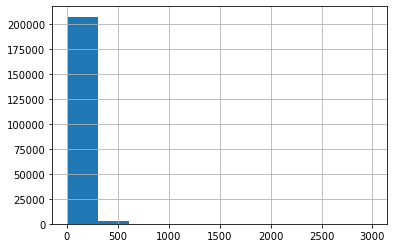

In [14]:
next_arrive_t = bus_tr['next_arrive_time']
next_arrive_t.hist()
# 대부분의 데이터들이 0 ~ 200 정도에서 분포를 띄고 있음 
# target값의 최대가 660대이므로 적절한 700 대에서 target 값을 잘라낸 것이 유용하다고 판단   


In [15]:
# 이상치 제거 
bus_tr = bus_tr[bus_tr['next_arrive_time'] <= 700]
bus_tr.head()

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time
0,0,2019-10-15,405136001,7997025,360-1,33.456267,126.551750,제주대학교입구,06시,266.0,제대마을,33.457724,126.554014,24
1,1,2019-10-15,405136001,7997025,360-1,33.457724,126.554014,제대마을,06시,333.0,제대아파트,33.458783,126.557353,36
2,2,2019-10-15,405136001,7997025,360-1,33.458783,126.557353,제대아파트,06시,415.0,제주대학교,33.459893,126.561624,40
3,3,2019-10-15,405136001,7997025,360-1,33.479705,126.543811,남국원(아라방면),06시,578.0,제주여자중고등학교(아라방면),33.484860,126.542928,42
4,4,2019-10-15,405136001,7997025,360-1,33.485662,126.494923,도호동,07시,374.0,은남동,33.485822,126.490897,64


#### 정류장 이름 인코딩

In [16]:
# xgboost 사용을 위해 문자열을 숫자형으로 변환 

In [17]:
station = list(bus_tr['now_station'].values) + list(bus_tr['next_station'].values) # train 의 모든 정류장 이름
station_set = set(station)
print(len(station_set))

351


In [18]:
station_encoder = LabelEncoder()        # 인코더 생성
station_encoder.fit(list(station_set))  # 인코딩 

# train 정류장 치환
bus_tr['now_station'] = station_encoder.transform(bus_tr['now_station'])
bus_tr['next_station'] = station_encoder.transform(bus_tr['next_station'])

# test 정류장 치환 
bus_te['now_station'] = station_encoder.transform(bus_te['now_station'])
bus_te['next_station'] = station_encoder.transform(bus_te['next_station'])
bus_tr.head()

<ipython-input-18-3660ff4b9b81>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bus_tr['now_station'] = station_encoder.transform(bus_tr['now_station'])
<ipython-input-18-3660ff4b9b81>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bus_tr['next_station'] = station_encoder.transform(bus_tr['next_station'])


,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time
0,0,2019-10-15,405136001,7997025,360-1,33.456267,126.551750,239,06시,266.0,227,33.457724,126.554014,24
1,1,2019-10-15,405136001,7997025,360-1,33.457724,126.554014,227,06시,333.0,228,33.458783,126.557353,36
2,2,2019-10-15,405136001,7997025,360-1,33.458783,126.557353,228,06시,415.0,235,33.459893,126.561624,40
3,3,2019-10-15,405136001,7997025,360-1,33.479705,126.543811,41,06시,578.0,249,33.484860,126.542928,42
4,4,2019-10-15,405136001,7997025,360-1,33.485662,126.494923,63,07시,374.0,221,33.485822,126.490897,64


#### 필요없는 featuere 제거

In [19]:
# train

bus_tr = bus_tr.drop(['id', 'route_nm', 'next_latitude', 'next_longitude', 
                              'now_latitude', 'now_longitude'], axis=1)
bus_tr.head()

,date,route_id,vh_id,now_station,now_arrive_time,distance,next_station,next_arrive_time
0,2019-10-15,405136001,7997025,239,06시,266.0,227,24
1,2019-10-15,405136001,7997025,227,06시,333.0,228,36
2,2019-10-15,405136001,7997025,228,06시,415.0,235,40
3,2019-10-15,405136001,7997025,41,06시,578.0,249,42
4,2019-10-15,405136001,7997025,63,07시,374.0,221,64


In [20]:
# test
bus_te = bus_te.drop(['id', 'route_nm', 'next_latitude', 'next_longitude', 
                              'now_latitude', 'now_longitude'], axis=1)
bus_te.head()

,date,route_id,vh_id,now_station,now_arrive_time,distance,next_station
0,2019-10-29,405136001,7997025,227,07시,333.0,228
1,2019-10-29,405136001,7997025,228,07시,415.0,235
2,2019-10-29,405136001,7997025,323,08시,417.0,59
3,2019-10-29,405136001,7997025,59,08시,334.0,183
4,2019-10-29,405136001,7997025,183,08시,550.0,285


#### 날짜 -> 요일

In [21]:
# train 

bus_tr['date'] = pd.to_datetime(bus_tr['date']) # date 값을 datetime으로
bus_tr['weekday'] = bus_tr['date'].dt.weekday  # Monday 0 ~ Sunday 6 
bus_tr = bus_tr.drop('date', axis=1) # 필요없는 date 칼럼을 drop
bus_tr.head()

,route_id,vh_id,now_station,now_arrive_time,distance,next_station,next_arrive_time,weekday
0,405136001,7997025,239,06시,266.0,227,24,1
1,405136001,7997025,227,06시,333.0,228,36,1
2,405136001,7997025,228,06시,415.0,235,40,1
3,405136001,7997025,41,06시,578.0,249,42,1
4,405136001,7997025,63,07시,374.0,221,64,1


In [22]:
bus_tr['weekday'].unique()

array([1, 2, 3, 4, 5, 6, 0], dtype=int64)

In [23]:
# test

bus_te['date'] = pd.to_datetime(bus_te['date'])
bus_te['weekday'] = bus_te['date'].dt.weekday 
bus_te = bus_te.drop('date', axis=1)
bus_te.head()

,route_id,vh_id,now_station,now_arrive_time,distance,next_station,weekday
0,405136001,7997025,227,07시,333.0,228,1
1,405136001,7997025,228,07시,415.0,235,1
2,405136001,7997025,323,08시,417.0,59,1
3,405136001,7997025,59,08시,334.0,183,1
4,405136001,7997025,183,08시,550.0,285,1


#### now_arrive_time -> 정수형으로 "06시" -> "06"

In [24]:
np.sort(bus_tr['now_arrive_time'].unique())
# 01시 ~ 04시의 데이터가 존재하지 않는다 -> 새벽 시간대 버스 운행X 

array(['00시', '05시', '06시', '07시', '08시', '09시', '10시', '11시', '12시',
       '13시', '14시', '15시', '16시', '17시', '18시', '19시', '20시', '21시',
       '22시', '23시'], dtype=object)

In [25]:
bus_tr[bus_tr['now_arrive_time']=='00시']

,route_id,vh_id,now_station,now_arrive_time,distance,next_station,next_arrive_time,weekday
147641,405320116,7983065,267,00시,259.0,268,20,3
147642,405320116,7983065,268,00시,1942.0,155,134,3
147643,405320116,7983065,14,00시,767.0,24,76,3
147644,405320116,7983065,135,00시,348.0,131,36,3
147645,405320116,7983065,131,00시,134.0,132,14,3


In [26]:
# '00시' -> '24시' 
# now_arrive_time 칼럼의 00을 24시로 바꿔치기

bus_tr.loc[(bus_tr.now_arrive_time == '00시'), 'now_arrive_time'] = '24시'
bus_te.loc[(bus_te.now_arrive_time == '00시'), 'now_arrive_time'] = '24시'
np.sort(bus_tr['now_arrive_time'].unique()), np.sort(bus_te['now_arrive_time'].unique())


(array(['05시', '06시', '07시', '08시', '09시', '10시', '11시', '12시', '13시',
        '14시', '15시', '16시', '17시', '18시', '19시', '20시', '21시', '22시',
        '23시', '24시'], dtype=object),
 array(['05시', '06시', '07시', '08시', '09시', '10시', '11시', '12시', '13시',
        '14시', '15시', '16시', '17시', '18시', '19시', '20시', '21시', '22시',
        '23시'], dtype=object))

C:\Users\ICT01_11\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ICT01_11\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0, flags=flags)


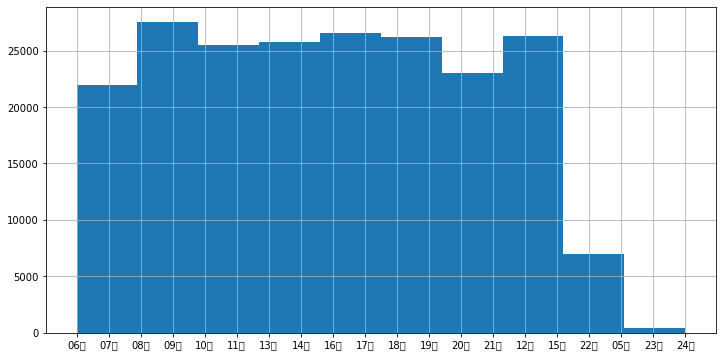

In [27]:
time = bus_tr['now_arrive_time']

plt.figure(figsize=(12,6))
plt.hist(time)
plt.grid(True)
plt.show()

In [28]:
bus_tr['now_arrive_time'] = bus_tr['now_arrive_time'].apply(lambda x:str(x)[:-1]).astype(int)
bus_tr

,route_id,vh_id,now_station,now_arrive_time,distance,next_station,next_arrive_time,weekday
0,405136001,7997025,239,6,266.0,227,24,1
1,405136001,7997025,227,6,333.0,228,36,1
2,405136001,7997025,228,6,415.0,235,40,1
3,405136001,7997025,41,6,578.0,249,42,1
4,405136001,7997025,63,7,374.0,221,64,1
...,...,...,...,...,...,...,...,...
210452,405328102,7983486,95,21,528.0,108,96,0
210453,405328102,7983486,65,21,280.0,81,50,0
210454,405328102,7983486,122,21,114.0,178,16,0
210455,405328102,7983486,178,21,223.0,298,38,0


In [29]:
bus_te['now_arrive_time'] = bus_te['now_arrive_time'].apply(lambda x:str(x)[:-1]).astype(int)
bus_te

,route_id,vh_id,now_station,now_arrive_time,distance,next_station,weekday
0,405136001,7997025,227,7,333.0,228,1
1,405136001,7997025,228,7,415.0,235,1
2,405136001,7997025,323,8,417.0,59,1
3,405136001,7997025,59,8,334.0,183,1
4,405136001,7997025,183,8,550.0,285,1
...,...,...,...,...,...,...,...
91769,405328102,7983486,255,20,272.0,10,1
91770,405328102,7983486,10,20,447.0,245,1
91771,405328102,7983486,245,20,418.0,22,1
91772,405328102,7983486,22,20,140.0,287,1


In [30]:
np.sort(bus_tr['now_arrive_time'].unique())

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24])

## 시각화

#### 각 요일별, 시간대별 타겟 평균

<function matplotlib.pyplot.show(close=None, block=None)>

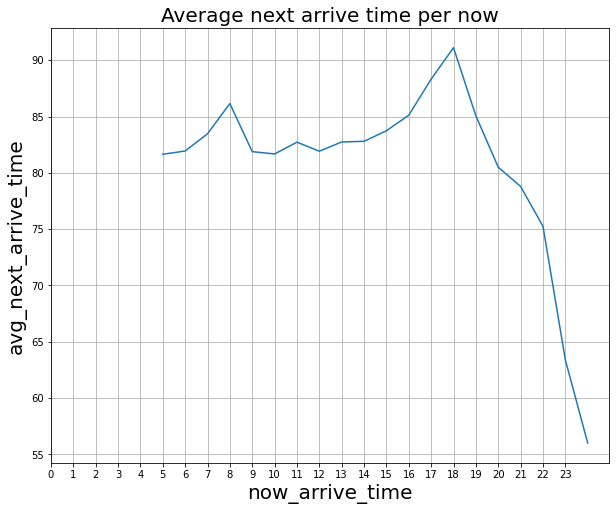

In [31]:
# 시간별 평균 이동시간 

bus_tr.groupby(bus_tr['now_arrive_time'])['next_arrive_time'].mean().plot(figsize=(10,8))
plt.xlabel('now_arrive_time', fontsize=20)
plt.ylabel('avg_next_arrive_time', fontsize=20)
plt.title('Average next arrive time per now', fontsize=20)
plt.xticks([0, 1, 2, 3, 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23])
plt.grid(True)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

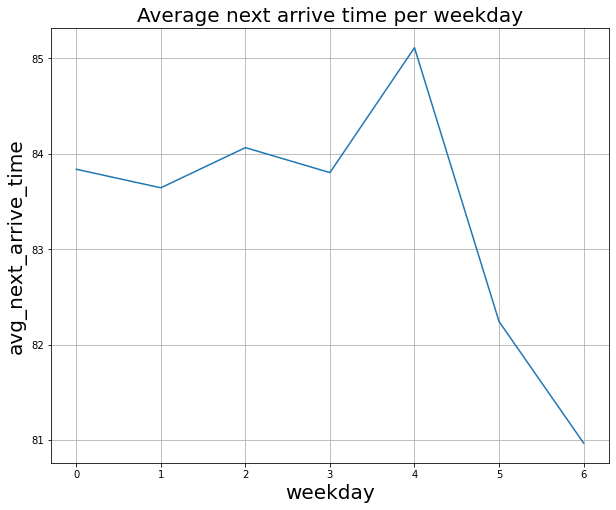

In [32]:
# 요일별 평균 이동 시간 
bus_tr.groupby(bus_tr['weekday'])['next_arrive_time'].mean().plot(figsize=(10,8))
plt.xlabel('weekday', fontsize=20)
plt.ylabel('avg_next_arrive_time', fontsize=20)
plt.title('Average next arrive time per weekday', fontsize=20)
plt.grid(True)
plt.show

# 0 : 월요일 ~  6 : 일요일 


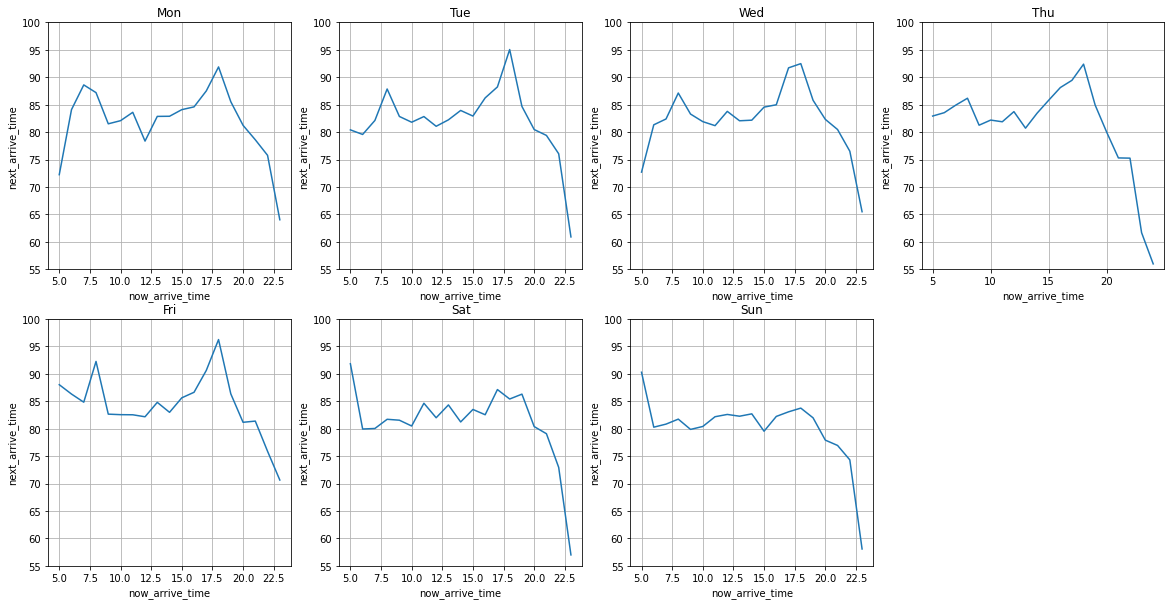

In [38]:
# 각 요일의 도착시간별 평균이동시간
legend = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

plt.figure(figsize=(20,10))
for i in range(7):
    plt.subplot(2,4,i+1)
    plt.plot(bus_tr.groupby('weekday').get_group(i).groupby('now_arrive_time').mean()['next_arrive_time'])
    plt.gca().set_title(legend[i])
    plt.xlabel('now_arrive_time')
    plt.ylabel('next_arrive_time')
    plt.ylim(55,100)
    plt.grid(True)

    # 그래프 y축 동일하게 맞춰줄 필요 O 

In [34]:
# 토,일(5,6)만 오전 5시대 이동시간이 김 -> 갑자기 아님.. 
# 확실히 주중 퇴근시간대에 이동시간이 길어지고 주말은 고른 이동시간 

# 토요일 오전 5시 이동시간 평균 91 / max 392 
bus_weekend = bus_tr[bus_tr['weekday']==6]
bus_weekend[bus_weekend['now_arrive_time']==6].describe()



,route_id,vh_id,now_station,now_arrive_time,distance,next_station,next_arrive_time,weekday
count,8.430000e+02,8.430000e+02,843.00000,843.0,843.000000,843.000000,843.000000,843.0
mean,4.052334e+08,7.989844e+06,172.45433,6.0,473.182681,173.241993,80.263345,6.0
std,9.327401e+04,6.933308e+03,98.34905,0.0,509.927991,98.216873,58.973418,0.0
min,4.051360e+08,7.983005e+06,0.00000,6.0,114.000000,0.000000,14.000000,6.0
25%,4.051365e+08,7.983092e+06,71.50000,6.0,291.000000,72.000000,42.000000,6.0
50%,4.053201e+08,7.983485e+06,184.00000,6.0,374.000000,185.000000,62.000000,6.0
75%,4.053201e+08,7.997062e+06,248.50000,6.0,516.000000,252.000000,102.000000,6.0
max,4.053281e+08,7.997124e+06,350.00000,6.0,7461.000000,350.000000,558.000000,6.0


In [35]:
a = bus_weekend[bus_weekend['now_arrive_time']==6]
a[a['next_arrive_time']==558]

,route_id,vh_id,now_station,now_arrive_time,distance,next_station,next_arrive_time,weekday
90032,405328102,7983409,152,6,7185.0,141,558,6


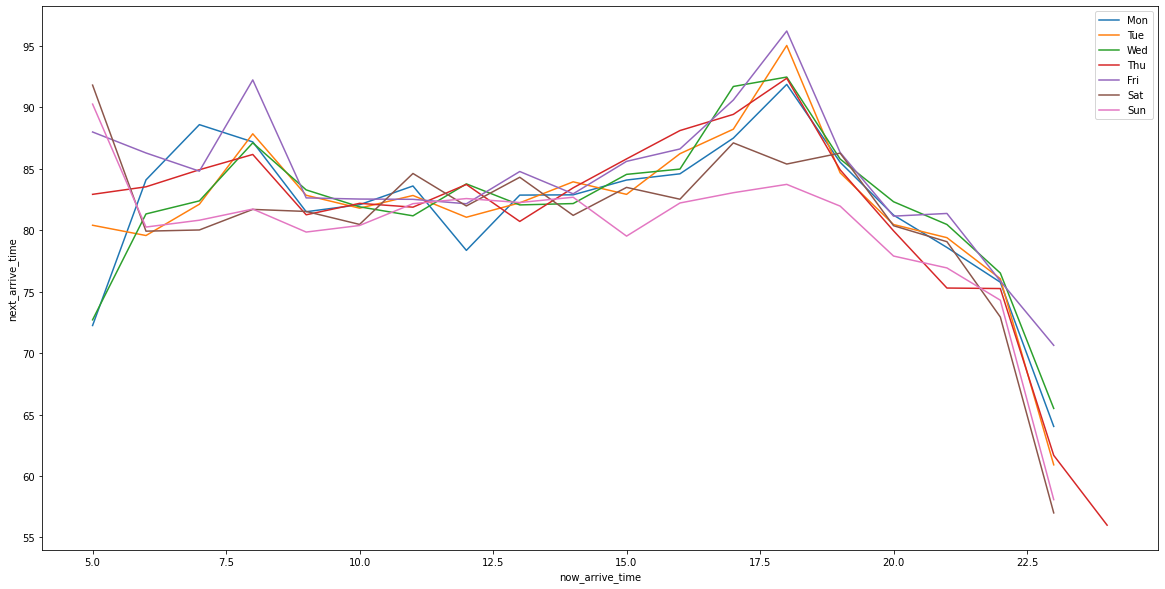

In [36]:
plt.figure(figsize=(20,10))
for i in range(7):
    plt.plot(bus_tr.groupby('weekday').get_group(i).groupby('now_arrive_time').mean()['next_arrive_time'])
plt.legend(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel('now_arrive_time')
plt.ylabel('next_arrive_time')
plt.show()

### 과제

- 목요일에만 존재하는 00시 데이터가 test 데이터에도 존재하는지 확인 필요 -> X, 24시 데이터로 바꿔줌
- 새벽 5시 시간대에 버스 이동시간이 모든 요일마다 높게 나오는데 데이터에 이상치 제거 후 전처리 재필요
- > 이상치 제거 후 토, 일만 그러한 현상이 발생/ 90초~ 100초면 1분 30/40초로 그리 긴 시간이 아님, 토, 일은 주중과 비교하여 변동의 폭이 높지 않다는 것만 강조합시다.
- Xgboost를 이용한 학습 예측 
